In [36]:
import numpy as np
from matplotlib import pyplot as plt


In [60]:
start_points = [-0.5, -0.25, 0, 0.4, 0.5]
end_points = [0.25, 0.25, 0, 0.5, 0.75]

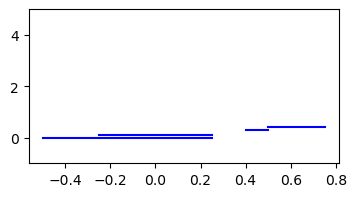

In [61]:
def plot_segments(start_points: np.ndarray, end_points: np.ndarray) -> None:
    plt.figure(figsize=(4,2))
    n_points = len(start_points)
    for i in range(n_points):
        elevation = 0.5 * i / n_points
        plt.plot([start_points[i], end_points[i]], [elevation, elevation], 'b')

    plt.ylim(-1, 5)
    plt.show()

plot_segments(np.array(start_points), np.array(end_points))


In [62]:
def stitch(start_points: np.ndarray, end_points: np.ndarray, q1_eps: float, eps: float) -> np.ndarray:
    # Concatenate start_points and end_points
    segment_points = np.unique(np.concatenate((start_points, end_points)))
    segment_points = np.sort(segment_points)

    segments = np.array([start_points, end_points]).T

    score_card = np.zeros(len(segment_points) - 1) # the last element of the score card is always 0 
    length_card = np.zeros(len(segment_points) - 1) # the last element of the length card is always 0 because it is not populated

    for i in range(len(segment_points) - 1):
        score = 0
        segment_start = segment_points[i]
        segment_end = segment_points[i+1]
        
        # Segment score is the number of segments that contain the segment
        for j in range(len(segments)):
            if segment_start >= segments[j][0] and segment_end <= segments[j][1]:
                score += 1
        score_card[i] = score

        # Segment length is the length of the segment
        length_card[i] = segment_end - segment_start

    
    # Tolerating zero score segments: computing length threshold
    if q1_eps is not None:
        # Use statistical threshold values
        q1_value = np.percentile(score_card, 25)
        zss_segment_thr = q1_value * q1_eps
    
    elif eps is not None:
        zss_segment_thr = eps
    
    else:
        raise ValueError("Either q1_eps or eps must be provided to provide tolerance for zero score segments (ZSS)")


    # Tolerating zero score segments: score improvement for tolerated segments
    for i in range(len(score_card)):
        if score_card[i] == 0:
            if length_card[i] < zss_segment_thr and i >= 1:
                score_card[i] = score_card[i-1]

    # Find the starting point and ending point of the longest non-zero score segment
    max_segment_length = 0
    max_segment_start = 0
    max_segment_end = 0
    current_segment_length = 0
    current_segment_start = 0
    current_segment_end = 0
    for i in range(len(score_card)):
        if score_card[i] != 0:
            current_segment_length += 1
            current_segment_end = i + 1
        else: # score_card[i] == 0
            if current_segment_length > max_segment_length:
                max_segment_length = current_segment_length
                max_segment_start = current_segment_start
                max_segment_end = current_segment_end
            current_segment_length = 0
            current_segment_start = i + 1
            current_segment_end = i + 1

    if current_segment_length > max_segment_length:
        max_segment_length = current_segment_length
        max_segment_start = current_segment_start
        max_segment_end = current_segment_end

    return segment_points[max_segment_start:max_segment_end]

In [63]:
stitched_points = stitch(np.array(start_points), np.array(end_points), q1_eps=0.1, eps=None)
stitched_points

array([-0.5 , -0.25,  0.  ])